# Dynamic topic modelling via Non-negative Matrix Factorization (NMF)

Warning: running the whole notebook requires more than 16Gb RAM. 
However you can run steps 1 and 2 separately

In [ ]:
# ! pip3 install gensim
# ! pip3 install razdel
# ! pip3 install pymorphy2

Import some preprocessing tools

In [2]:
import sys
sys.path.insert(0, '../../../preprocessing')
import preprocessing_tools as preprocessing_tools

In [3]:
import pandas as pd;
import numpy as np;
import scipy as sp;
import sklearn;
import sys;
from nltk.corpus import stopwords;
import nltk;
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer;
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;
import re;
from io import StringIO;
from nltk.corpus import stopwords
import gc

In [4]:
# data_file = "~/Projects/project_news/proj_news_viz/interfax_sorted_2008-02-11_2019-01-19.csv"
data_file = "~/Downloads/topic_news/topici_i_rubrici_go.csv"

# Step 1: Preprocessing

Here we will process input .csv line by line as far as the separator "|" happens to be a part of the message body for some entries

In [ ]:
date  = []
url   = []
host  = []
topic = []
title = []
body  = []
with open('../../../../../../project_news/interfax_sorted_2008-02-11_2019-01-19.csv') as news_file:
    for line in news_file:
        fields = line.split("|")
        date.append(fields[0])
        url.append(fields[1])
        host.append(fields[2])
        topic.append(fields[3])
        title.append(fields[4])
        body.append(" ".join(fields[5:]))
    news_file.close()
data_prep = pd.DataFrame({'date' : date,
                          'url'  : url,
                          'host' : host,
                          'topic': topic,
                          'title': title,
                          'body' : body},
                         columns={'date', 'url', 'host', 'topic', 'title', 'body'})
del data_prep
del date
del url
del host
del topic
del title
del body
gc.collect()
data_prep.info()

In [5]:
data = pd.read_csv(data_file,
                   sep=',',
                   encoding='utf-8',
                   error_bad_lines=False);
# data.columns = ["date", "url", "host", "topic", "title", "body"]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235915 entries, 0 to 235914
Data columns (total 5 columns):
short_topic     235915 non-null object
short_rubric    235915 non-null object
newtext         235915 non-null object
year_text       235915 non-null object
topic_rubric    235915 non-null object
dtypes: object(5)
memory usage: 9.0+ MB


As we can see, 106 entries are lost due to extra separators. However, I assume, it is not critical.

In [6]:
data.head()

,short_topic,short_rubric,newtext,year_text,topic_rubric
0,Библиотека,Первая мировая,бой сопоцкина друскеник закончиться отступлени...,1914-09 бой сопоцкина друскеник закончиться от...,Библиотека/Первая мировая
1,Библиотека,Первая мировая,министерство народный просвещение вид происход...,1914-09 министерство народный просвещение вид ...,Библиотека/Первая мировая
2,Библиотека,Первая мировая,фотограф-корреспондент daily mirror рассказыва...,1914-09 фотограф-корреспондент daily mirror ра...,Библиотека/Первая мировая
3,Библиотека,Первая мировая,штабс-капитан п н нестер день увидеть район же...,1914-09 штабс-капитан п н нестер день увидеть ...,Библиотека/Первая мировая
4,Библиотека,Первая мировая,лицо приехать варшава люблин передавать туда д...,1914-09 лицо приехать варшава люблин передават...,Библиотека/Первая мировая


In [7]:
data["short_rubric"].value_counts()

Политика             31015
Общество             25833
Украина              16929
Происшествия         14912
Футбол               12089
Госэкономика         11988
Кино                  8640
Бизнес                7994
Интернет              7247
Наука                 6728
Следствие и суд       6193
Музыка                5283
Люди                  4708
Преступность          4563
Космос                3389
События               3072
Конфликты             2964
Coцсети               2814
Летние виды           2803
ТВ и радио            2722
Деловой климат        2442
Криминал              2369
Явления               2271
Регионы               2239
Гаджеты               2123
Мир                   2092
Бокс и ММА            2080
Игры                  2061
Звери                 2008
Стиль                 1882
                     ...  
Еда                    430
Молдавия               425
Катастрофы             404
Вещи                   393
Реклама                360
Автобизнес             310
И

In [8]:
rubric = "Политика"
data_politics = pd.DataFrame(data.loc[data["short_rubric"] == "Политика"])
data_politics.head(10)

,short_topic,short_rubric,newtext,year_text,topic_rubric
16,Россия,Политика,махачкала четверг 27 декабрь задержать лидер д...,2012-12 махачкала четверг 27 декабрь задержать...,Россия/Политика
27,Россия,Политика,премьер-министр рф дмитрий медведев утвердить ...,2013-12 премьер-министр рф дмитрий медведев ут...,Россия/Политика
48,Мир,Политика,оппозиционный демонстрант утром 1 декабрь захв...,2013-12 оппозиционный демонстрант утром 1 дека...,Мир/Политика
49,Мир,Политика,премьер-министр таиланд йинглак чинават 1 дека...,2013-12 премьер-министр таиланд йинглак чинава...,Мир/Политика
58,Россия,Политика,губернатор калужский область анатолий артамон ...,2013-12 губернатор калужский область анатолий ...,Россия/Политика
61,Мир,Политика,демонстрант бангкок 2 декабрь отправиться штур...,2013-12 демонстрант бангкок 2 декабрь отправит...,Мир/Политика
91,Мир,Политика,комиссия разработка конституция египет воскрес...,2013-12 комиссия разработка конституция египет...,Мир/Политика
96,Мир,Политика,глава комиссия оон право человек навь пиллай 2...,2013-12 глава комиссия оон право человек навь ...,Мир/Политика
106,Россия,Политика,фонд развитие гражданский общество форго предл...,2013-12 фонд развитие гражданский общество фор...,Россия/Политика
145,Мир,Политика,китай начало 2013 год около 20 тысяча чиновник...,2013-12 китай начало 2013 год около 20 тысяча ...,Мир/Политика


In [9]:
data_social = data.loc[data["short_rubric"] == "Общество"]
data_social.head()

,short_topic,short_rubric,newtext,year_text,topic_rubric
8,Мир,Общество,власть район столица южный корея запустить про...,2009-11 власть район столица южный корея запус...,Мир/Общество
43,Россия,Общество,часы действие закон отмена мобильный рабство в...,2013-12 часы действие закон отмена мобильный р...,Россия/Общество
72,Мир,Общество,израильский премьер-министр биньямин нетанияга...,2013-12 израильский премьер-министр биньямин н...,Мир/Общество
75,Россия,Общество,модный дом louis vuitton оштрафовать 10 тысяча...,2013-12 модный дом louis vuitton оштрафовать 1...,Россия/Общество
76,Мир,Общество,китайский режиссёр чжан имоу признать нарушить...,2013-12 китайский режиссёр чжан имоу признать ...,Мир/Общество


In [10]:
data_ukraina = data.loc[data["short_rubric"] == "Украина"]
data_ukraina.head()

,short_topic,short_rubric,newtext,year_text,topic_rubric
18,Бывший СССР,Украина,сторонник евроинтеграция украина вернуться май...,2013-12 сторонник евроинтеграция украина верну...,Бывший СССР/Украина
19,Бывший СССР,Украина,боец спецподразделение беркут жёстко оттеснить...,2013-12 боец спецподразделение беркут жёстко о...,Бывший СССР/Украина
23,Бывший СССР,Украина,окружный административный суд киев удовлетвори...,2013-12 окружный административный суд киев удо...,Бывший СССР/Украина
26,Бывший СССР,Украина,украинский делегация следующий неделя отправит...,2013-12 украинский делегация следующий неделя ...,Бывший СССР/Украина
28,Бывший СССР,Украина,ход уличный столкновение центр киев пострадать...,2013-12 ход уличный столкновение центр киев по...,Бывший СССР/Украина


In [11]:
from datetime import datetime
data_politics["date"] = data_politics["year_text"].apply(lambda x: datetime.strptime(x.split(" ")[0], '%Y-%m'))

In [12]:
data_politics["date"].head(20)

16    2012-12-01
27    2013-12-01
48    2013-12-01
49    2013-12-01
58    2013-12-01
61    2013-12-01
91    2013-12-01
96    2013-12-01
106   2013-12-01
145   2013-12-01
157   2013-12-01
168   2013-12-01
182   2013-12-01
196   2013-12-01
206   2013-12-01
222   2013-12-01
232   2013-12-01
237   2013-12-01
261   2013-12-01
275   2013-12-01
Name: date, dtype: datetime64[ns]

In [13]:
data_politics["cleaned_text"] = data_politics["newtext"].apply(preprocessing_tools.clean_text)
data_politics[["cleaned_text"]].head()

../../../preprocessing/preprocessing_tools.py:28: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|[\"]", '', text)


,cleaned_text
16,махачкала четверг декабрь задержать лидер даг...
27,премьерминистр рф дмитрий медведев утвердить с...
48,оппозиционный демонстрант утром декабрь захва...
49,премьерминистр таиланд йинглак чинават декабр...
58,губернатор калужский область анатолий артамон ...


In [14]:
# stopword_ru = stopwords.words('russian')
stopword_ru = "../../../preprocessing/stopwords.txt"
data_politics["tokenized_text"] = data_politics["cleaned_text"].apply(preprocessing_tools.lemmatization, stopword=stopword_ru)
data_politics[["tokenized_text"]].head()

,tokenized_text
16,"[махачкала, задержать, лидер, дагестанский, от..."
27,"[премьерминистр, рф, дмитрий, медведев, утверд..."
48,"[оппозиционный, демонстрант, утром, захватить,..."
49,"[премьерминистр, таиланд, йинглак, чинават, вс..."
58,"[губернатор, калужский, область, анатолий, арт..."


NMF expects input texts as strings

In [15]:
data_politics["tockens"] = data_politics["tokenized_text"].tolist()
data_politics["pp_text"] = data_politics["tokenized_text"].apply(lambda x: " ".join(x))
data_politics.head()

,short_topic,short_rubric,newtext,year_text,topic_rubric,date,cleaned_text,tokenized_text,tockens,pp_text
16,Россия,Политика,махачкала четверг 27 декабрь задержать лидер д...,2012-12 махачкала четверг 27 декабрь задержать...,Россия/Политика,2012-12-01,махачкала четверг декабрь задержать лидер даг...,"[махачкала, задержать, лидер, дагестанский, от...","[махачкала, задержать, лидер, дагестанский, от...",махачкала задержать лидер дагестанский отделен...
27,Россия,Политика,премьер-министр рф дмитрий медведев утвердить ...,2013-12 премьер-министр рф дмитрий медведев ут...,Россия/Политика,2013-12-01,премьерминистр рф дмитрий медведев утвердить с...,"[премьерминистр, рф, дмитрий, медведев, утверд...","[премьерминистр, рф, дмитрий, медведев, утверд...",премьерминистр рф дмитрий медведев утвердить с...
48,Мир,Политика,оппозиционный демонстрант утром 1 декабрь захв...,2013-12 оппозиционный демонстрант утром 1 дека...,Мир/Политика,2013-12-01,оппозиционный демонстрант утром декабрь захва...,"[оппозиционный, демонстрант, утром, захватить,...","[оппозиционный, демонстрант, утром, захватить,...",оппозиционный демонстрант утром захватить штаб...
49,Мир,Политика,премьер-министр таиланд йинглак чинават 1 дека...,2013-12 премьер-министр таиланд йинглак чинава...,Мир/Политика,2013-12-01,премьерминистр таиланд йинглак чинават декабр...,"[премьерминистр, таиланд, йинглак, чинават, вс...","[премьерминистр, таиланд, йинглак, чинават, вс...",премьерминистр таиланд йинглак чинават встреча...
58,Россия,Политика,губернатор калужский область анатолий артамон ...,2013-12 губернатор калужский область анатолий ...,Россия/Политика,2013-12-01,губернатор калужский область анатолий артамон ...,"[губернатор, калужский, область, анатолий, арт...","[губернатор, калужский, область, анатолий, арт...",губернатор калужский область анатолий артамон ...


In [16]:
data_politics['docID'] = list(range(data_politics.shape[0]))
data_politics['year'] = data_politics['date'].dt.year
data_politics['month'] = data_politics['date'].dt.month
data_politics.head()

,short_topic,short_rubric,newtext,year_text,topic_rubric,date,cleaned_text,tokenized_text,tockens,pp_text,docID,year,month
16,Россия,Политика,махачкала четверг 27 декабрь задержать лидер д...,2012-12 махачкала четверг 27 декабрь задержать...,Россия/Политика,2012-12-01,махачкала четверг декабрь задержать лидер даг...,"[махачкала, задержать, лидер, дагестанский, от...","[махачкала, задержать, лидер, дагестанский, от...",махачкала задержать лидер дагестанский отделен...,0,2012,12
27,Россия,Политика,премьер-министр рф дмитрий медведев утвердить ...,2013-12 премьер-министр рф дмитрий медведев ут...,Россия/Политика,2013-12-01,премьерминистр рф дмитрий медведев утвердить с...,"[премьерминистр, рф, дмитрий, медведев, утверд...","[премьерминистр, рф, дмитрий, медведев, утверд...",премьерминистр рф дмитрий медведев утвердить с...,1,2013,12
48,Мир,Политика,оппозиционный демонстрант утром 1 декабрь захв...,2013-12 оппозиционный демонстрант утром 1 дека...,Мир/Политика,2013-12-01,оппозиционный демонстрант утром декабрь захва...,"[оппозиционный, демонстрант, утром, захватить,...","[оппозиционный, демонстрант, утром, захватить,...",оппозиционный демонстрант утром захватить штаб...,2,2013,12
49,Мир,Политика,премьер-министр таиланд йинглак чинават 1 дека...,2013-12 премьер-министр таиланд йинглак чинава...,Мир/Политика,2013-12-01,премьерминистр таиланд йинглак чинават декабр...,"[премьерминистр, таиланд, йинглак, чинават, вс...","[премьерминистр, таиланд, йинглак, чинават, вс...",премьерминистр таиланд йинглак чинават встреча...,3,2013,12
58,Россия,Политика,губернатор калужский область анатолий артамон ...,2013-12 губернатор калужский область анатолий ...,Россия/Политика,2013-12-01,губернатор калужский область анатолий артамон ...,"[губернатор, калужский, область, анатолий, арт...","[губернатор, калужский, область, анатолий, арт...",губернатор калужский область анатолий артамон ...,4,2013,12


Save preprocessed texts into a file

In [ ]:
with open('./clean.texts.txt', 'wt') as out_file:
    for doc in texts_clean:
        out_file.write(doc + '\n')
    out_file.close()

# Step 2: Topic modelling

In [23]:
# https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730
def get_nmf_topics(model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

While some topics are pretty clear:
Topic #1 - что-то связанное с передачей информации
Topic #2 - происшествия, несчастные случаи
Topic #3 - финансы, валюта
Topic #4 - футбол
Topic #5 - судебные дела
Topic #6 - пожары
Topic #7 - инциденты с авиационной техникой
...

Nevertheless, some topics overlap (like 7 and 90)

In [ ]:
topics.to_csv('../lenta.topics.%s.csv' % rubric)

In [55]:
documents = data_politics["pp_text"]
documents = documents.tolist()
documents[:2]

['махачкала задержать лидер дагестанский отделение партия яблоко артур бабаев прессслужба партия днём бабаев подъехать офис партия адрес улица юсуп обнаружить здание оцепить попытаться выяснить причина оцепление задержать бабаев доставить ленинский ровд махачкала махачкалинский офис яблоко сеять пора оцепить причина полицейский оцепить офис партия задержать бабаев неизвестно комментарий правоохранительный орган повод пока поступать отделение партия яблоко появиться дагестан возглавить брат артур бабаев фарид бабаев выбор госдума смертельно ранить глава партия встать артур бабаев организатор убийство первое глава дагестанский яблоко найти',
 'премьерминистр рф дмитрий медведев утвердить состав совет русский язык правительство россия соответствующий распоряжение разместить сайт правительство совет возглавить вицепремьер ольга голодец заместитель министр образование дмитрий ливан помимо орган войти сми образовательный культурный федеральный региональный чиновник совет русский язык утверди

In [18]:
max_features = 300
vectorizer = CountVectorizer(analyzer='word', max_features=max_features);
x_counts = vectorizer.fit_transform(documents);
print(x_counts.shape)

(31015, 300)


In [19]:
transformer = TfidfTransformer(smooth_idf=False);
x_tfidf = transformer.fit_transform(x_counts);

In [20]:
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

In [21]:
num_topics = 30
model = NMF(n_components=num_topics, init='nndsvd');
model.fit(xtfidf_norm)

NMF(alpha=0.0, beta_loss='frobenius', init='nndsvd', l1_ratio=0.0,
  max_iter=200, n_components=30, random_state=None, shuffle=False,
  solver='cd', tol=0.0001, verbose=0)

In [ ]:
# import pickle
# filename = './nmf.lentaru.sav'
# pickle.dump(model, open(filename, 'wb'))

In [24]:
topics = get_nmf_topics(model, 20)
topics

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,...,Topic # 21,Topic # 22,Topic # 23,Topic # 24,Topic # 25,Topic # 26,Topic # 27,Topic # 28,Topic # 29,Topic # 30
0,россия,выбор,трамп,путин,иго,кндр,навальный,депутат,сирия,турция,...,клинтон,иран,крым,акция,закон,самолёт,министр,мэр,встреча,бывший
1,российский,избирательный,дональд,владимир,исламский,корея,алексей,госдума,сирийский,турецкий,...,кандидат,ядерный,полуостров,задержать,законопроект,российский,лавров,кандидат,лидер,обвинение
2,москва,голосование,сша,государство,боевик,северный,москва,парламент,асад,анкара,...,госсекретарь,программа,референдум,участник,документ,военный,иностранный,москва,саммит,расследование
3,дипломат,голос,дом,россия,государство,ракета,написать,комитет,оон,власть,...,пост,соглашение,республика,движение,право,граница,мид,сергей,переговоры,сотрудник
4,мид,кандидат,американский,глава,группировка,южный,срок,палата,оппозиция,попытка,...,штат,оружие,состав,власть,принять,произойти,сергей,пост,франция,информация
5,посол,комиссия,написать,российский,террористический,ядерный,сергей,единый,удар,посол,...,сша,санкция,регион,москва,совет,погибнуть,глава,должность,визит,великобритания
6,сергей,президентский,штат,ход,ирак,оон,борьба,заседание,сила,военный,...,бывший,международный,житель,проходить,проект,китай,ведомство,выбор,состояться,власть
7,рф,единый,администрация,вопрос,запретить,военный,заседание,председатель,оружие,погибнуть,...,голос,китай,россия,около,гражданин,дать,оборона,отставка,германия,обвинять
8,новость,кампания,президентский,развитие,террорист,полуостров,обвинять,россия,военный,граница,...,сенатор,республика,право,участие,решение,расследование,министерство,занимать,китай,дать
9,риа,день,кампания,кремль,территория,агентство,заявление,список,конфликт,операция,...,политик,исламский,признать,проведение,палата,район,германия,местный,сторона,издание


In [25]:
res = model.transform(xtfidf_norm)

In [66]:
feature_names = vectorizer.get_feature_names()

In [27]:
print(res.shape)
len(feature_names)
model.components_.shape

(31015, 30)


(30, 300)

In [28]:
id_date = data_politics[['docID', 'year', 'month']].copy()
dt = pd.DataFrame(res)
dt = id_date.join(dt)
dt.columns = ['docID', 'year', 'month'] + ["Topic_%d" % i for i in range(1, 31)]
dt.head()

,docID,year,month,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,...,Topic_21,Topic_22,Topic_23,Topic_24,Topic_25,Topic_26,Topic_27,Topic_28,Topic_29,Topic_30
16,0,2012,12,0.000998,0.000241,0.000000,0.000000,0.003369,0.001359,0.003808,...,0.000058,0.000000,0.000000,0.003893,0.000000,0.001505,0.000000,0.000000,0.000455,0.015245
27,1,2013,12,0.000830,0.000000,0.000958,0.004765,0.004048,0.000450,0.000308,...,0.000000,0.000000,0.002295,0.000740,0.017318,0.006256,0.042685,0.000000,0.000000,0.000481
48,2,2013,12,0.000482,0.000000,0.000000,0.000000,0.010543,0.000000,0.000000,...,0.000000,0.002016,0.000659,0.002123,0.001499,0.001130,0.000000,0.000000,0.018599,0.002583
49,3,2013,12,0.000000,0.000000,0.000000,0.000000,0.000000,0.049368,0.000000,...,0.000867,0.000000,0.000000,0.000000,0.000850,0.002388,0.000000,0.002914,0.016180,0.012125
58,4,2013,12,0.000000,0.004886,0.000047,0.002727,0.010754,0.004528,0.000000,...,0.000000,0.000000,0.001683,0.000000,0.007633,0.000000,0.000000,0.000000,0.010699,0.030689


In [29]:
dt['year_month'] = dt.apply(lambda x: str(int(x.year)) +'-'+ str(int(x.month)) + '-01', axis=1)
dt.reset_index(inplace=True)
dt.head()

,index,docID,year,month,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,...,Topic_22,Topic_23,Topic_24,Topic_25,Topic_26,Topic_27,Topic_28,Topic_29,Topic_30,year_month
0,16,0,2012,12,0.000998,0.000241,0.000000,0.000000,0.003369,0.001359,...,0.000000,0.000000,0.003893,0.000000,0.001505,0.000000,0.000000,0.000455,0.015245,2012-12-01
1,27,1,2013,12,0.000830,0.000000,0.000958,0.004765,0.004048,0.000450,...,0.000000,0.002295,0.000740,0.017318,0.006256,0.042685,0.000000,0.000000,0.000481,2013-12-01
2,48,2,2013,12,0.000482,0.000000,0.000000,0.000000,0.010543,0.000000,...,0.002016,0.000659,0.002123,0.001499,0.001130,0.000000,0.000000,0.018599,0.002583,2013-12-01
3,49,3,2013,12,0.000000,0.000000,0.000000,0.000000,0.000000,0.049368,...,0.000000,0.000000,0.000000,0.000850,0.002388,0.000000,0.002914,0.016180,0.012125,2013-12-01
4,58,4,2013,12,0.000000,0.004886,0.000047,0.002727,0.010754,0.004528,...,0.000000,0.001683,0.000000,0.007633,0.000000,0.000000,0.000000,0.010699,0.030689,2013-12-01


In [30]:
joined_melt = dt.melt('year_month', var_name='topic', value_name='text')
print(joined_melt.shape)
joined_melt.head()

(1054510, 3)


,year_month,topic,text
0,2012-12-01,index,16.0
1,2013-12-01,index,27.0
2,2013-12-01,index,48.0
3,2013-12-01,index,49.0
4,2013-12-01,index,58.0


In [31]:
# select only topic_*
joined_melt_new = joined_melt[(joined_melt.topic!='docID') & (joined_melt.topic!='index')
                              & (joined_melt.topic!='year') & (joined_melt.topic!='month')]
print(joined_melt_new.shape)
joined_melt_new.topic.value_counts()

(930450, 3)


Topic_4     31015
Topic_22    31015
Topic_2     31015
Topic_24    31015
Topic_19    31015
Topic_12    31015
Topic_9     31015
Topic_5     31015
Topic_1     31015
Topic_25    31015
Topic_20    31015
Topic_28    31015
Topic_3     31015
Topic_23    31015
Topic_13    31015
Topic_14    31015
Topic_10    31015
Topic_7     31015
Topic_8     31015
Topic_17    31015
Topic_27    31015
Topic_30    31015
Topic_18    31015
Topic_15    31015
Topic_16    31015
Topic_11    31015
Topic_26    31015
Topic_29    31015
Topic_6     31015
Topic_21    31015
Name: topic, dtype: int64

In [64]:
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]]) for i in topic.argsort()[:-no_top_words - 1:-1])
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(documents[doc_index][:50])

In [ ]:
display_topics(model.components_, res.T, feature_names, documents, 4, 5)

Extract dominant topics for each document

In [ ]:
doc_topic = pd.DataFrame({'date':data["date"],
                          'topic':res.argmax(axis=1),
                          'body':documents},
                  columns=['date', 'topic', 'body'])

In [ ]:
doc_topic.to_csv('./nmf.lentaru.%s.dominant_topics.%d.csv' % (rubric, num_topics))

In [ ]:
doc_topic.head(30)

# Joypy

In [32]:
%matplotlib inline
import matplotlib
matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
import joypy # !pip install joypy

In [68]:
labels = sorted(joined_melt_new['year_month'].unique())
labels

['2012-12-01',
 '2013-1-01',
 '2013-10-01',
 '2013-11-01',
 '2013-12-01',
 '2013-2-01',
 '2013-3-01',
 '2013-4-01',
 '2013-5-01',
 '2013-6-01',
 '2013-7-01',
 '2013-8-01',
 '2013-9-01',
 '2014-1-01',
 '2014-10-01',
 '2014-11-01',
 '2014-12-01',
 '2014-2-01',
 '2014-3-01',
 '2014-4-01',
 '2014-5-01',
 '2014-6-01',
 '2014-7-01',
 '2014-8-01',
 '2014-9-01',
 '2015-1-01',
 '2015-10-01',
 '2015-11-01',
 '2015-12-01',
 '2015-2-01',
 '2015-3-01',
 '2015-4-01',
 '2015-5-01',
 '2015-6-01',
 '2015-7-01',
 '2015-8-01',
 '2015-9-01',
 '2016-1-01',
 '2016-10-01',
 '2016-11-01',
 '2016-12-01',
 '2016-2-01',
 '2016-3-01',
 '2016-4-01',
 '2016-5-01',
 '2016-6-01',
 '2016-7-01',
 '2016-8-01',
 '2016-9-01',
 '2017-1-01',
 '2017-10-01',
 '2017-11-01',
 '2017-12-01',
 '2017-2-01',
 '2017-3-01',
 '2017-4-01',
 '2017-5-01',
 '2017-6-01',
 '2017-7-01',
 '2017-8-01',
 '2017-9-01',
 '2018-1-01',
 '2018-2-01',
 '2018-3-01',
 '2018-4-01',
 '2018-5-01',
 '2018-6-01',
 '2018-7-01']

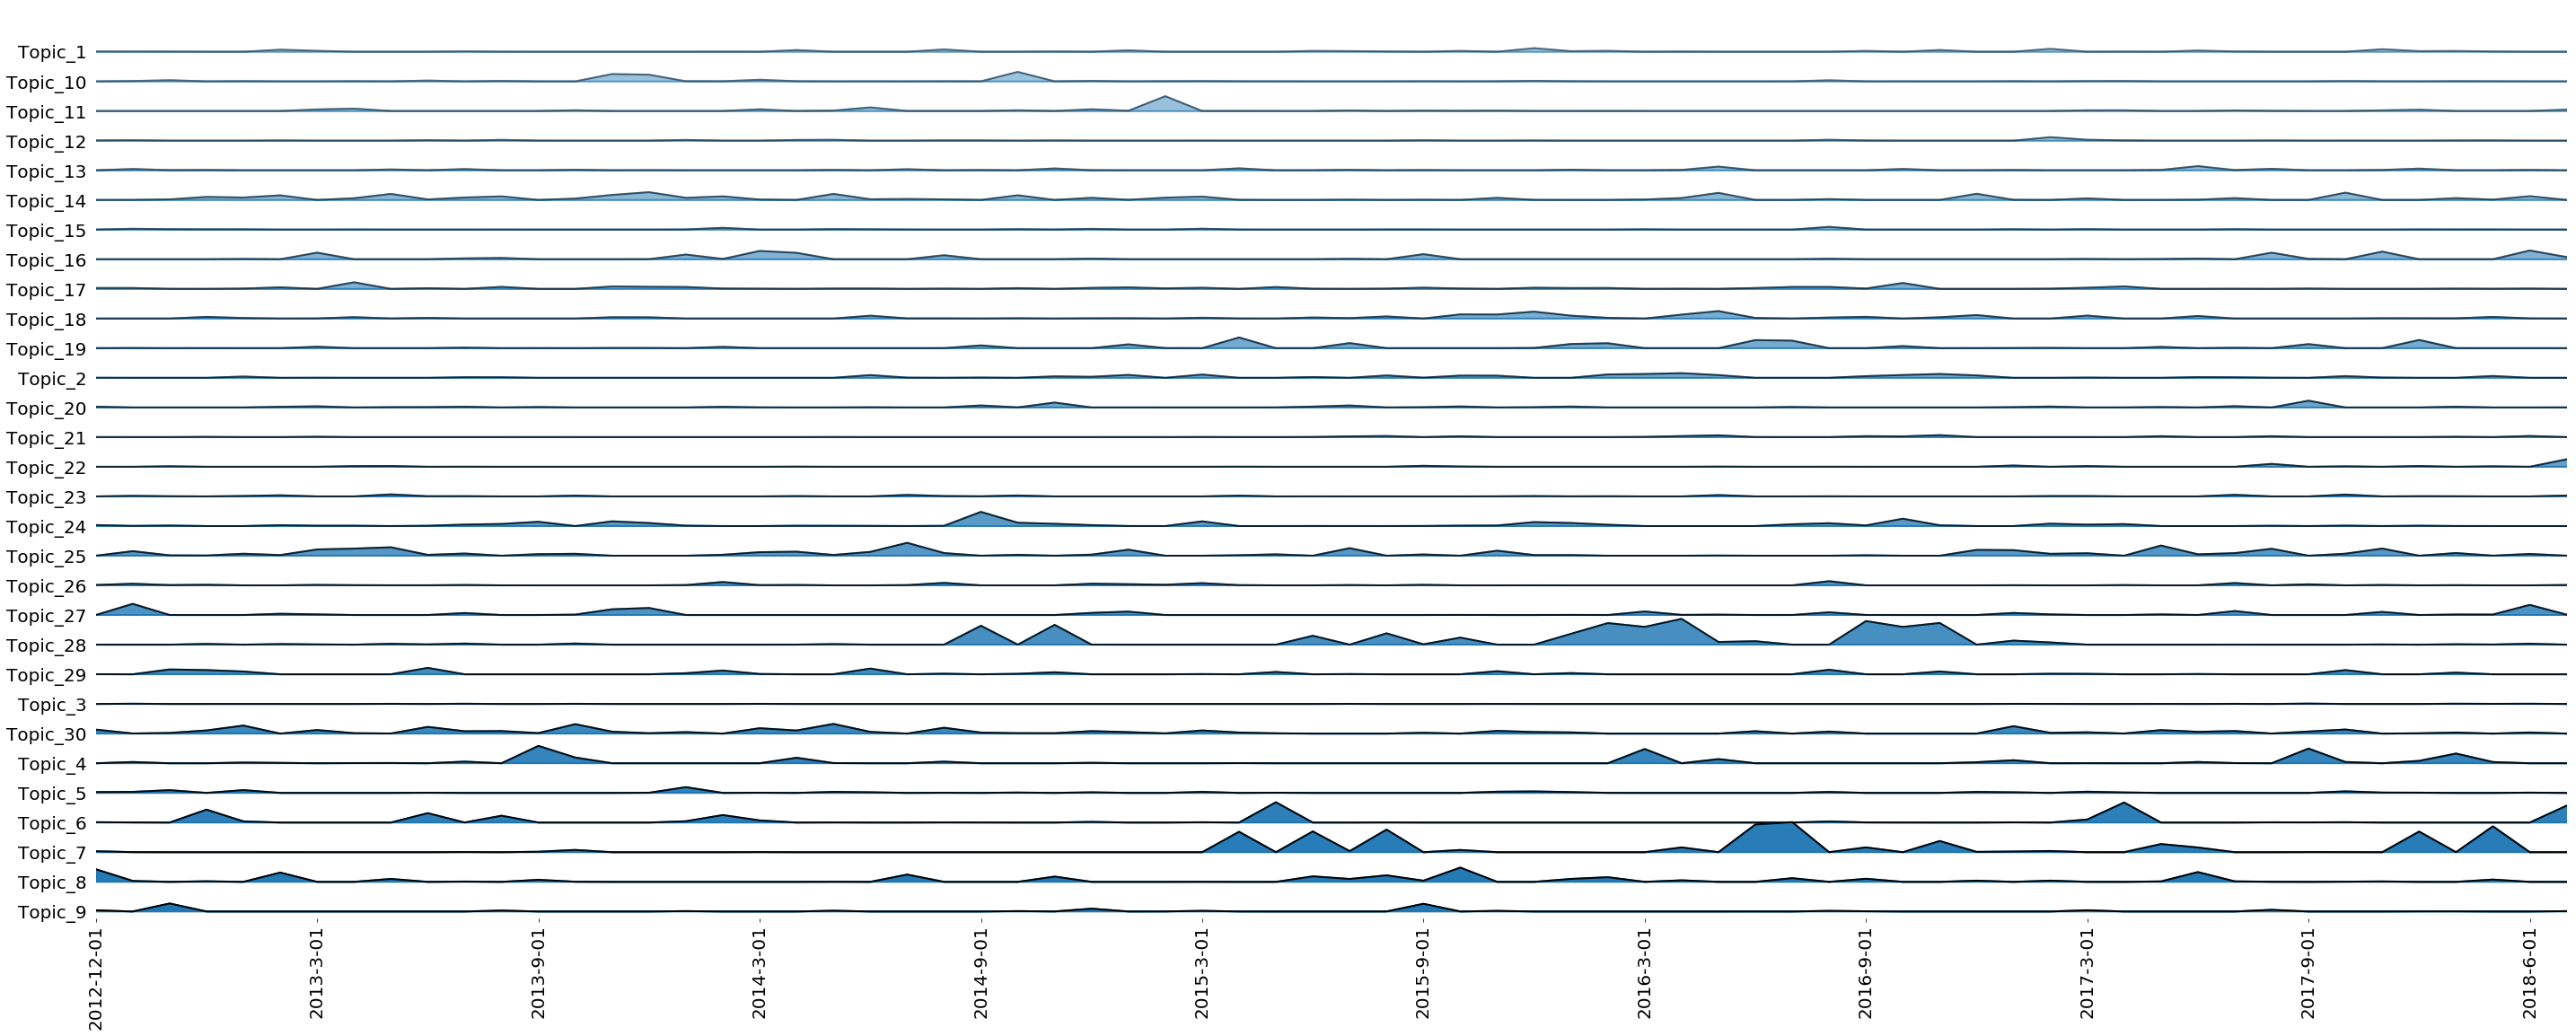

In [39]:
fig, axes = joypy.joyplot(joined_melt_new, by='topic', column='text', figsize=(40, 15),xlabelsize=20,ylabelsize=20,
                          overlap=0.7, fill=True, linecolor="k", linewidth=2,
                          kind='values', fade=True, xrot=90, x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);
plt.show()